## Решение задачи Римана о распаде разрыва

In [261]:
# Целью данной работы было применение схемы Куранта-Изаксона-Риса к задаче Римана о распаде разрыва. Рассматривается одномерный
# случай. В начале отсчёта находится перегородка, давления идеального газа по разные стороны которой отличаются в 10 раз.
# Моделируется эволюция системы с течением времени.

In [262]:
# Импортируем модули для хранения и визуализации расчётов
import numpy as np
import math as m
import matplotlib.pyplot as plt

# Определим параметры задачи
L = 10 # задача решается на отрезке [-L; L]
T = 0.015 # время моделирования
k = 5/3 # показатель адиабаты
MaxCFL = 1 # ограничение на число Куранта
dt = 10e-7 # шаг по времени
M = 101 # число узлов сетки
h = 2*L/(M-1) # шаг по координате
# Зададим параметры по разные стороны от перегородки
p_l = 10
p_r = 1
rho_l = 13
rho_r = 1.3
VecX = np.linspace(-L, L, M) # расчётная сетка

# Зададим начальные условия
rho_init = np.zeros(M)
p_init = np.zeros(M)
rho_init[0:int(M/2)+1]+=np.ones(int(M/2)+1)*rho_l
rho_init[int(M/2)+1:M]+=np.ones(int(M/2))*rho_r
p_init[0:int(M/2)+1]+=np.ones(int(M/2)+1)*p_l*101325
p_init[int(M/2)+1:M]+=np.ones(int(M/2))*p_r*101325
data_current = np.array([rho_init, np.zeros(M), p_init/(k-1)])
data_next = np.zeros([3,M])
time = 0

#Расчёт
for j in range(int(T/dt)):
    for i in range(1,M-1):
        u = (data_current[1]/data_current[0])[i]
        e = (data_current[2]/data_current[0])[i]
        c = ((data_current[2]/data_current[0])**0.5*m.sqrt(k**2-k))[i]
        OmegaT = np.array([[-u*c, c, k-1],
                           [-c**2, 0, k-1],
                           [u*c, -c, k-1]])
        OmegaT_inv = np.array([[1/2/c**2, -1/c**2, 1/2/c**2],
                              [(c+u)/2/c**2, -u/c**2, (-c+u)/2/c**2],
                              [1/2/(k-1), 0, 1/2/(k-1)]])
        Lambda = np.array([[u+c, 0, 0],
                          [0, u, 0],
                          [0, 0, u-c]])
        AbsLambda = np.array([[abs(u+c), 0, 0],
                              [0, abs(u), 0],
                              [0, 0, abs(u-c)]])
        A = np.array([[0, 1, 0],
                     [-u**2, 2*u, k-1],
                     [-e*u*k, e*k, u]])
        lamb = max (abs(u+c), abs(u-c))
        # Скорректируем шаг по времени, если это необходимо:
        if (dt*lamb/h > 1):
            dt = h/lamb
        # Переходим в консервативные переменные
        w = np.array([data_current[0][i], data_current[1][i], data_current[2][i]])
        wp = np.array([data_current[0][i-1], data_current[1][i-1], data_current[2][i-1]])
        wn = np.array([data_current[0][i+1], data_current[1][i+1], data_current[2][i+1]])
        # Решаем уравнения на консервативные переменные
        w_new = w - dt*A@(wn-wp)/2/h+dt/2/h*OmegaT_inv@AbsLambda@OmegaT@(wn-2*w+wp)
        for e in range(3):
            data_next[e][i] = w_new[e]
    for e in range(3):
        data_next[e][0] = data_next[e][1]
        data_next[e][M-1] = data_next[e][M-2]
    time+=dt
    data_current = data_next

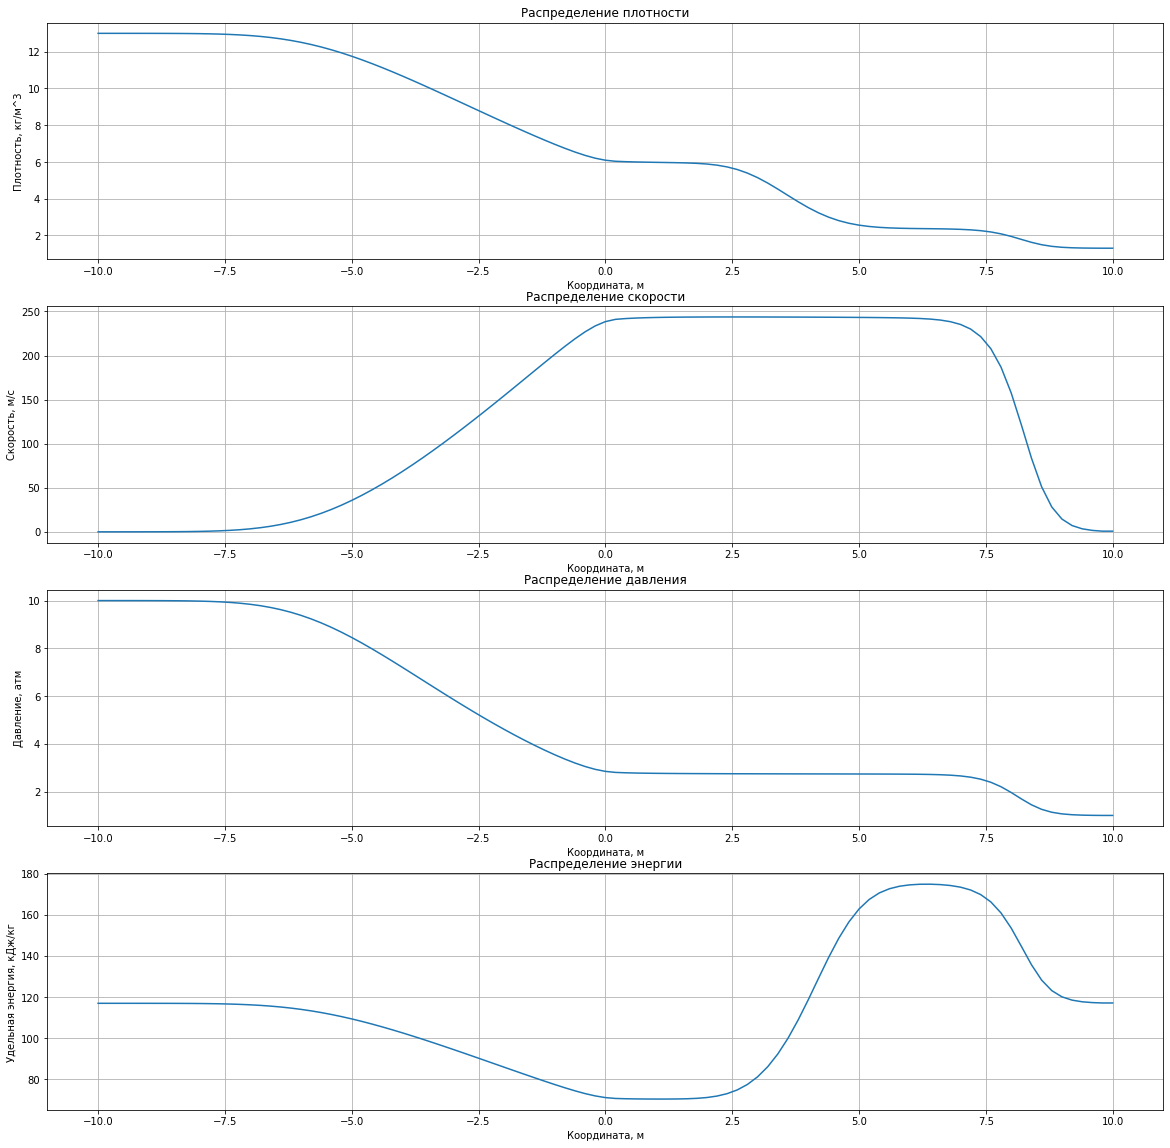

In [263]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20))

axs[0].set_title('Распределение плотности')
_ = axs[0].set_xlabel('Координата, м')
_ = axs[0].set_ylabel('Плотность, кг/м^3')
_ = axs[0].plot(VecX, data_current[0])
_ = axs[0].grid()

axs[1].set_title('Распределение скорости')
_ = axs[1].set_xlabel('Координата, м')
_ = axs[1].set_ylabel('Скорость, м/с')
_ = axs[1].plot(VecX, data_current[1]/data_current[0])
_ = axs[1].grid()

axs[2].set_title('Распределение давления')
_ = axs[2].set_xlabel('Координата, м')
_ = axs[2].set_ylabel('Давление, атм')
_ = axs[2].plot(VecX, data_current[2]*(k-1)/101325)
_ = axs[2].grid()

axs[3].set_title('Распределение энергии')
_ = axs[3].set_xlabel('Координата, м')
_ = axs[3].set_ylabel('Удельная энергия, кДж/кг')
_ = axs[3].plot(VecX, data_current[2]/data_current[0]/1000)
_ = axs[3].grid()